In [1]:
#%%

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

<h1> Amazon Datasets </h1>

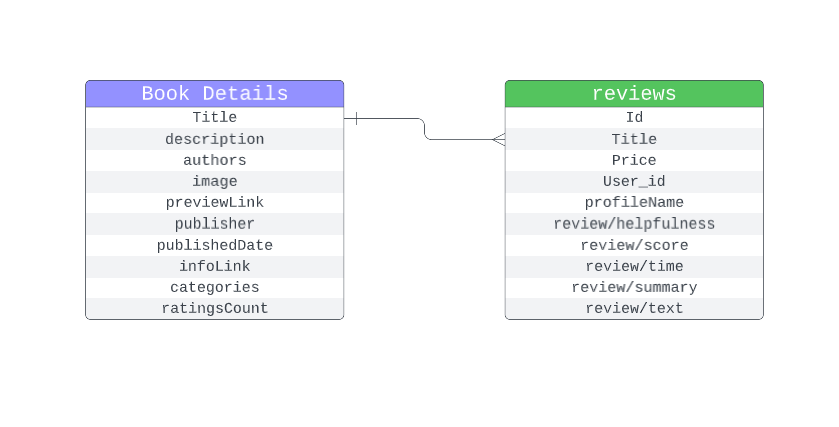

<h1> Goodreads Datasets </h1>

<p>Meta-Data of Books <br>
Detailed book graph (~2gb, about 2.3m books): goodreads_books.json.gz <br>
Detailed information of authors: goodreads_book_authors.json.gz <br>
Detailed information of works (i.e., the abstract version of a book regardless any particular editions): goodreads_book_works.json.gz <br>
Detailed information of book series (Note: Unfortunately, the series id included here cannot be used for URL hack): goodreads_book_series.json.gz <br>
Extracted fuzzy book genres (genre tags are extracted from users' popular shelves by a simple keyword matching process): goodreads_book_genres_initial.json.gz <br></p>

In [2]:
#%%

# Function to get the total number of lines in a file
def get_total_lines(file_path):
    with open(file_path, 'r') as f:
        return sum(1 for _ in f)

# Function to read JSON in chunks with progress bar
def read_json_in_chunks(file_path, chunk_size=500):
    total_lines = get_total_lines(file_path)
    chunk_list = []
    with pd.read_json(file_path, lines=True, chunksize=chunk_size) as reader:
        for chunk in tqdm(reader, desc=f"Loading {file_path}", total=total_lines//chunk_size, unit="chunk"):
            chunk_list.append(chunk)
    return pd.concat(chunk_list, ignore_index=True)

In [4]:
goodreads_book_authors = read_json_in_chunks('../data/goodreads_book_authors.json')
goodreads_book_series = read_json_in_chunks('../data/goodreads_book_series.json')
goodreads_book_works = read_json_in_chunks('../data/goodreads_book_works.json')

Loading ../data/goodreads_book_authors.json: 1660chunk [00:06, 245.05chunk/s]                       
Loading ../data/goodreads_book_series.json: 801chunk [00:03, 211.91chunk/s]                      
Loading ../data/goodreads_book_works.json: 3044chunk [00:25, 118.47chunk/s]                       


In [5]:
print(goodreads_book_authors.info())
print(goodreads_book_works.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829529 entries, 0 to 829528
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   average_rating      829529 non-null  float64
 1   author_id           829529 non-null  int64  
 2   text_reviews_count  829529 non-null  int64  
 3   name                829529 non-null  object 
 4   ratings_count       829529 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 31.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521962 entries, 0 to 1521961
Data columns (total 16 columns):
 #   Column                             Non-Null Count    Dtype 
---  ------                             --------------    ----- 
 0   books_count                        1521962 non-null  int64 
 1   reviews_count                      1521962 non-null  int64 
 2   original_publication_month         1521962 non-null  object
 3   default_description_language_

In [111]:
goodreads_book_authors['name']

0         Ronald J. Fields
1            Anita Diamant
2           Barbara Hambly
3          Jennifer Weiner
4            Nigel Pennick
                ...       
829524       Patty Furbush
829525      Jim Schlinkman
829526          Rich Jolly
829527           sr@ mwrGn
829528      Barry S. Brown
Name: name, Length: 829529, dtype: object

# Explore book works

In [109]:
print(goodreads_book_works['rating_dist'])

0                               5:1|4:1|3:1|2:0|1:0|total:3
1                5:517|4:1787|3:2763|2:966|1:196|total:6229
2                          5:49|4:58|3:26|2:5|1:3|total:141
3          5:9152|4:16855|3:19507|2:6210|1:1549|total:53273
4                              5:6|4:1|3:3|2:3|1:2|total:15
                                 ...                       
1521957                       5:13|4:5|3:3|2:1|1:0|total:22
1521958                         5:0|4:0|3:0|2:2|1:0|total:2
1521959                       5:5|4:10|3:4|2:0|1:0|total:19
1521960                         5:1|4:2|3:2|2:1|1:0|total:6
1521961                      5:12|4:18|3:8|2:2|1:0|total:40
Name: rating_dist, Length: 1521962, dtype: object


In [112]:
def split_rating_dist(df):
    ratings_split = df['rating_dist'].str.split('|', expand=True)
    
    ratings_dict = {'rating_1': [], 'rating_2': [], 'rating_3': [], 'rating_4': [], 'rating_5': []}

    for _, row in ratings_split.iterrows():
        row_ratings = {'rating_1': 0, 'rating_2': 0, 'rating_3': 0, 'rating_4': 0, 'rating_5': 0}
        
        for part in row.dropna():
            rating, count = part.split(':')
            if rating.isdigit():
                row_ratings[f'rating_{rating}'] = int(count)
        
        for key in ratings_dict:
            ratings_dict[key].append(row_ratings[key])
    
    for key in ratings_dict:
        df[key] = ratings_dict[key]
    
    return df

goodreads_book_works = split_rating_dist(goodreads_book_works)

goodreads_book_works.drop(columns=['rating_dist'], inplace=True)

print(goodreads_book_works[['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']].head())

   rating_1  rating_2  rating_3  rating_4  rating_5
0         0         0         1         1         1
1       196       966      2763      1787       517
2         3         5        26        58        49
3      1549      6210     19507     16855      9152
4         2         3         3         1         6


In [113]:
goodreads_book_authors.rename(columns=lambda x: 'author_' + x, inplace=True)
goodreads_book_works.rename(columns=lambda x: 'works_' + x, inplace=True)

print(goodreads_book_authors.info())
print(goodreads_book_works.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829529 entries, 0 to 829528
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   author_average_rating      829529 non-null  float64
 1   author_author_id           829529 non-null  int64  
 2   author_text_reviews_count  829529 non-null  int64  
 3   author_name                829529 non-null  object 
 4   author_ratings_count       829529 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 31.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521962 entries, 0 to 1521961
Data columns (total 20 columns):
 #   Column                                   Non-Null Count    Dtype 
---  ------                                   --------------    ----- 
 0   works_books_count                        1521962 non-null  int64 
 1   works_reviews_count                      1521962 non-null  int64 
 2   works_original_public

In [80]:
print(goodreads_book_series.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400390 entries, 0 to 400389
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   numbered            400390 non-null  object
 1   note                400390 non-null  object
 2   description         400390 non-null  object
 3   title               400390 non-null  object
 4   series_works_count  400390 non-null  int64 
 5   series_id           400390 non-null  int64 
 6   primary_work_count  400390 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 21.4+ MB
None


In [102]:
def perform_eda(chunk_df):
    print(chunk_df.info())

In [104]:
def extract_first_author_id(authors):
    if isinstance(authors, list) and len(authors) > 0 and isinstance(authors[0], dict):
        return authors[0].get('author_id', None)
    return None

def extract_first_series(authors):
        if authors:
            return authors[0]
        return None

def merge_and_perform_eda_in_chunks():
    file_path = '../data/goodreads_books.json'
    total_lines = get_total_lines(file_path)
    with pd.read_json(file_path, lines=True, chunksize=1000) as reader:
        for chunk in tqdm(reader, desc=f"Loading {file_path}", total=total_lines//1000, unit="chunk"): 
            # Extract the first author_id from the authors array
            chunk['first_author_id'] = chunk['authors'].apply(extract_first_author_id)
            chunk['first_author_id'].fillna(-1, inplace=True)
            chunk['first_author_id'] = pd.to_numeric(chunk['first_author_id'], errors='coerce').astype('Int64')

            # Merge with goodreads_book_authors
            merged_df = pd.merge(chunk, goodreads_book_authors, left_on='first_author_id', right_on='author_id', how='inner')

            # Merge with goodreads_book_works
            merged_df = pd.merge(merged_df, goodreads_book_works, on='work_id', how='left')

            # Merge with goodreads_book_series
            merged_df['series'] = merged_df['series'].apply(extract_first_series)
            merged_df['series'].fillna(-1, inplace=True)
            merged_df['series'] = pd.to_numeric(merged_df['series'], errors='coerce').astype('Int64')
            merged_df = pd.merge(merged_df, goodreads_book_series, left_on='series', right_on='series_id', how='left')
            
            # merged_df.drop('column_name', axis=1, inplace=True)
            break
    perform_eda(merged_df)
            
merge_and_perform_eda_in_chunks()

Loading ../data/goodreads_books.json:   0%|          | 0/2360 [00:01<?, ?chunk/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 57 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   isbn                               1000 non-null   object 
 1   text_reviews_count_x               1000 non-null   int64  
 2   series                             1000 non-null   Int64  
 3   country_code                       1000 non-null   object 
 4   language_code                      1000 non-null   object 
 5   popular_shelves                    1000 non-null   object 
 6   asin                               1000 non-null   object 
 7   is_ebook                           1000 non-null   object 
 8   average_rating_x                   1000 non-null   float64
 9   kindle_asin                        1000 non-null   object 
 10  similar_books                      1000 non-null   object 
 11  description_x                      1000 non-null   object